In [1]:
from rdkit import Chem
from rdkit.Chem.Scaffolds.MurckoScaffold import (
    GetScaffoldForMol,
    MakeScaffoldGeneric,
    MurckoScaffoldSmilesFromSmiles
)

m = Chem.MolFromSmiles("Cc1ccccc1")
scaffold = GetScaffoldForMol(m)
Chem.MolToSmiles(scaffold)



'c1ccccc1'

In [2]:
import pandas as pd

data = pd.read_csv("../data/aqsoldb.csv")
smiles = data["SMILES"].to_numpy()
smiles

array(['[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C', 'O=C1Nc2cccc3cccc1c23',
       'Clc1ccc(C=O)cc1', ..., 'c1(cc(ccc1C(C)C)C)O',
       'COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2)cc1OC',
       'CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O'], dtype=object)

In [13]:
import numpy as np
from rdkit import RDLogger

groups = {}
for s in smiles:
    scaffold = MurckoScaffoldSmilesFromSmiles(s)
    if scaffold == "":
        mol = Chem.MolFromSmiles(s)
        s = Chem.MolToSmiles(mol, isomericSmiles=True)
        scaffold = MurckoScaffoldSmilesFromSmiles(s)
    # else:
    #     scaffold = Chem.MolToSmiles(
    #         MakeScaffoldGeneric(
    #             GetScaffoldForMol(
    #                 Chem.MolFromSmiles(s))))
    if scaffold in groups:
        groups[scaffold].append(s)
    else:
        groups[scaffold] = [s]

# groups = np.array([MurckoScaffoldSmilesFromSmiles(s) for s in smiles])

[23:55:47] WARNING: not removing hydrogen atom without neighbors
[23:55:47] WARNING: not removing hydrogen atom without neighbors
[23:55:47] WARNING: not removing hydrogen atom without neighbors
[23:55:47] WARNING: not removing hydrogen atom without neighbors
[23:55:47] WARNING: not removing hydrogen atom without neighbors
[23:55:47] WARNING: not removing hydrogen atom without neighbors
[23:55:47] WARNING: not removing hydrogen atom without neighbors
[23:55:47] WARNING: not removing hydrogen atom without neighbors
[23:55:47] WARNING: not removing hydrogen atom without neighbors
[23:55:47] WARNING: not removing hydrogen atom without neighbors
[23:55:47] WARNING: not removing hydrogen atom without neighbors
[23:55:47] WARNING: not removing hydrogen atom without neighbors
[23:55:47] WARNING: not removing hydrogen atom without neighbors
[23:55:47] WARNING: not removing hydrogen atom without neighbors
[23:55:47] WARNING: not removing hydrogen atom without neighbors
[23:55:47] WARNING: not r

2940
7042
[1.000e+00 1.753e+03 1.000e+00 ... 1.000e+00 1.000e+00 0.000e+00]


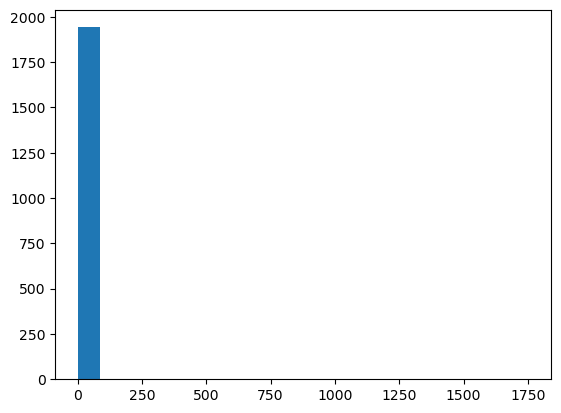

<Figure size 8000x600 with 0 Axes>

In [14]:
from matplotlib import pyplot as plt

xs = np.array([n for n in range(len(groups))])
ys = np.zeros(len(groups))

empty = groups.pop("")
print(len(empty))
print(sum([len(i) for _, i in groups.items()]))
for i, key in enumerate(groups.keys()):
    ys[i] = len(groups[key])

print(ys)
# [print(v) for v in groups.values()]
plt.hist(ys, bins=20)
plt.figure(figsize=(80, 6))
plt.show()

In [6]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_tanimoto_similarity(mols):
    fps = [AllChem.GetMorganFingerprint(mol, 2) for mol in mols]
    return [
        DataStructs.BulkTanimotoSimilarity(fp, fps) for fp in tqdm(fps)
    ]

df = data

# Convert SMILES to RDKit molecules
df['Molecule'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))

# Calculate Tanimoto similarity matrix
molecules = df['Molecule'].tolist()
tanimoto_matrix = calculate_tanimoto_similarity(molecules)


[18:50:08] WARNING: not removing hydrogen atom without neighbors
[18:50:08] WARNING: not removing hydrogen atom without neighbors
[18:50:08] WARNING: not removing hydrogen atom without neighbors
[18:50:08] WARNING: not removing hydrogen atom without neighbors
[18:50:08] WARNING: not removing hydrogen atom without neighbors
[18:50:08] WARNING: not removing hydrogen atom without neighbors
[18:50:08] WARNING: not removing hydrogen atom without neighbors
[18:50:08] WARNING: not removing hydrogen atom without neighbors
[18:50:08] WARNING: not removing hydrogen atom without neighbors
[18:50:08] WARNING: not removing hydrogen atom without neighbors
[18:50:08] WARNING: not removing hydrogen atom without neighbors
[18:50:08] WARNING: not removing hydrogen atom without neighbors
[18:50:08] WARNING: not removing hydrogen atom without neighbors
[18:50:08] WARNING: not removing hydrogen atom without neighbors
[18:50:08] WARNING: not removing hydrogen atom without neighbors
[18:50:08] WARNING: not r

In [7]:
row1 = {
    "similarity": tanimoto_matrix[0],
    "smiles": smiles,
    "LogS": data["Solubility"]
}
pd.DataFrame(row1)

tanimoto_matrix_np = np.array(tanimoto_matrix)

In [8]:
# Set random seed for reproducibility
# np.random.seed(42)

import itertools

# Randomly sample molecule pairs
# num_samples = len(molecules)  # Specify the desired number of random pairs
# random_indices = np.random.choice(range(len(molecules)), size=(num_samples, 2), replace=True)
indices = list(itertools.combinations([i for i in range(len(molecules))], 2))
# print(random_indices)

# Calculate Tanimoto difference and solubility difference for each pair of molecules
num_molecules = len(molecules)
tanimoto_diffs = []
solubility_diffs = []

with tqdm(total=len(indices), desc="Calculating similarities") as pbar:
    for idx1, idx2 in indices:
        tanimoto_diff = 1 - tanimoto_matrix_np[idx1, idx2]
        solubility_diff = abs(df.loc[idx1, 'Solubility'] - df.loc[idx2, 'Solubility'])
        tanimoto_diffs.append(tanimoto_diff)
        solubility_diffs.append(solubility_diff)
        pbar.update(1)

tanimoto_similarity = pd.DataFrame({
    "TanimotoDiff": tanimoto_diffs,
    "LogSDiff": solubility_diffs
}).to_csv("tanimoto_logs_data.csv")

Calculating similarities: 100%|██████████| 49815171/49815171 [12:27<00:00, 66632.23it/s]


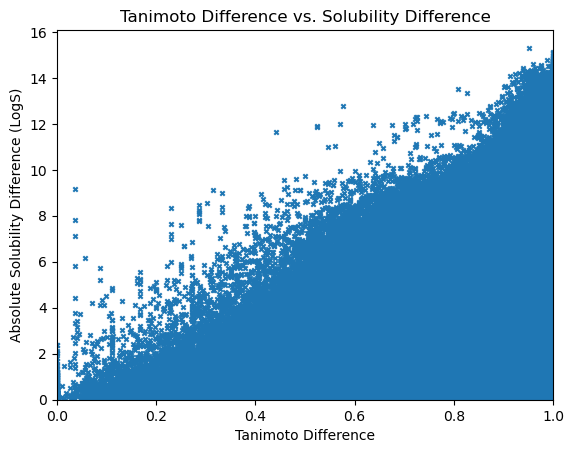

In [46]:
tanimoto_diffs = np.array(tanimoto_diffs)
solubility_diffs = np.array(solubility_diffs)


v = 1
plt.scatter(tanimoto_diffs[tanimoto_diffs <= v], solubility_diffs[tanimoto_diffs <= v], marker='x', s=10)
plt.xlabel("Tanimoto Difference")
plt.ylabel("Absolute Solubility Difference (LogS)")
plt.xlim(0, v)  # Set x-axis limits
plt.ylim(bottom=0)  # Set y-axis limits
plt.title("Tanimoto Difference vs. Solubility Difference")
plt.show()


[4.4476671  3.73488631]
[4.8928105  1.63227995]
[4.63299945 0.91004826]
[4.28524326 0.56349901]


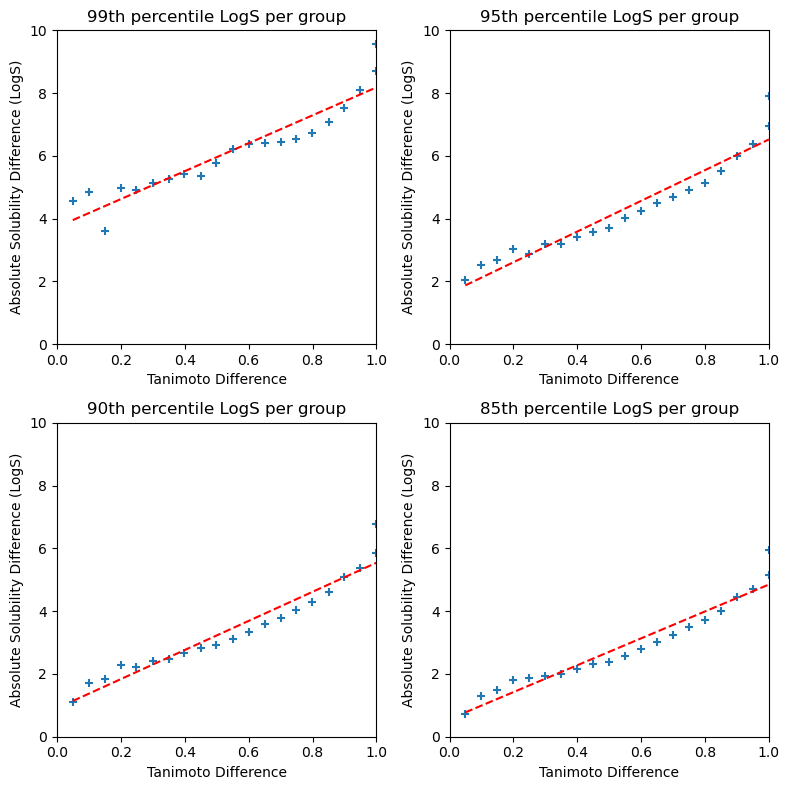

In [52]:
import math

from matplotlib.axis import Axis

def generate_percentile_data(percentile, axis: Axis):
    group_width = 0.05
    bins = np.arange(np.min(tanimoto_diffs), np.max(tanimoto_diffs) + group_width, group_width)
    group_indices = np.digitize(tanimoto_diffs, bins)
    unique_groups = np.unique(group_indices)

    percentile_95_values = []
    x_value_ranges = []
    for group in unique_groups:
        group_x_values = tanimoto_diffs[group_indices == group]
        min_x_value = np.min(group_x_values)
        max_x_value = np.max(group_x_values)
        x_value_ranges.append((min_x_value, max_x_value))
        
        group_y_values = solubility_diffs[group_indices == group]
        percentile_95 = np.percentile(group_y_values, percentile)
        percentile_95_values.append(percentile_95)

    x_maxes = [max_x for _, max_x in x_value_ranges]

    coefficients = np.polyfit(x_maxes, percentile_95_values, 1)
    print(coefficients)
    line_of_best_fit = np.poly1d(coefficients)
    line_x = np.linspace(np.min(x_maxes), np.max(x_maxes), 100)
    line_y = line_of_best_fit(line_x)
    axis.scatter(x_maxes, percentile_95_values, marker='+')
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 10)
    axis.set_title(f"{percentile}th percentile LogS per group")
    axis.set_xlabel("Tanimoto Difference")
    axis.set_ylabel("Absolute Solubility Difference (LogS)")
    axis.plot(line_x, line_y, 'r--', label='Line of Best Fit')
    return x_maxes, percentile_95_values

fig, axes = plt.subplots(2, 2, tight_layout=True, figsize=(8, 8))
x_maxes_all = []
percentile_values_all = []
for ax, percentile in zip(axes.flatten(), [99, 95, 90, 85]):
    x_maxes, percentile_values = generate_percentile_data(percentile, ax)
    x_maxes_all.append(x_maxes)
    percentile_values_all.append(percentile_values)


An increase of 0.1 tanimoto leads to a max increase of 0.489 logS.

Exact similarity has a max difference of 1.63 logS.

In [44]:
from scipy.stats import pearsonr

# [pearsonr(tanimoto_diffs[tanimoto_diffs <= v], solubility_diffs[tanimoto_diffs <= v]) for v in [0.05 * n for n in range(1, 21)]]
for x_maxes, percentile_values in zip(x_maxes_all, percentile_values_all):
    print(pearsonr(x_maxes, percentile_values))


PearsonRResult(statistic=0.9383791621650528, pvalue=3.271806098269373e-10)
PearsonRResult(statistic=0.9616258731992214, pvalue=3.984701453051046e-12)
PearsonRResult(statistic=0.9654906793071526, pvalue=1.4756399937583281e-12)
PearsonRResult(statistic=0.9660562943941443, pvalue=1.26402530017391e-12)


In [51]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import matplotlib.pyplot as plt
from tqdm import tqdm


train = pd.read_csv("../data/train.csv")
train["molecules"] = train['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
train["fingerprint"] = train["molecules"].apply(lambda m: AllChem.GetMorganFingerprint(m, 2))

validation = pd.read_csv("../data/validation.csv")
validation["molecules"] = validation['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
validation["fingerprint"] = validation["molecules"].apply(lambda m: AllChem.GetMorganFingerprint(m, 2))


def get_similarities(fp, fps):
    # fp = AllChem.GetMorganFingerprint(mol, 2)
    # fps = [AllChem.GetMorganFingerprint(m, 2) for m in mols]
    # print(fp, fps)
    return DataStructs.BulkTanimotoSimilarity(fp, fps)

[21:01:05] WARNING: not removing hydrogen atom without neighbors
[21:01:05] WARNING: not removing hydrogen atom without neighbors
[21:01:05] WARNING: not removing hydrogen atom without neighbors
[21:01:05] WARNING: not removing hydrogen atom without neighbors
[21:01:05] WARNING: not removing hydrogen atom without neighbors
[21:01:05] WARNING: not removing hydrogen atom without neighbors
[21:01:05] WARNING: not removing hydrogen atom without neighbors
[21:01:05] WARNING: not removing hydrogen atom without neighbors
[21:01:05] WARNING: not removing hydrogen atom without neighbors
[21:01:06] WARNING: not removing hydrogen atom without neighbors
[21:01:06] WARNING: not removing hydrogen atom without neighbors
[21:01:06] WARNING: not removing hydrogen atom without neighbors
[21:01:06] WARNING: not removing hydrogen atom without neighbors
[21:01:06] WARNING: not removing hydrogen atom without neighbors
[21:01:06] WARNING: not removing hydrogen atom without neighbors
[21:01:06] WARNING: not r

# Calculate similarities between train and validation sets

In [13]:

train_fps = list(train["fingerprint"])
validation_fps = list(validation["fingerprint"])
sim = np.zeros((len(validation), len(train)))

for i in tqdm(range(len(validation)), total=len(validation)):
    sim[i] = np.array(get_similarities(validation_fps[i], train_fps))


100%|██████████| 982/982 [00:07<00:00, 131.34it/s]


(array([870.,   0.,   0.,  81.,   0.,   0.,  23.,   0.,   0.,   0.,   7.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6,
        3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ]),
 <BarContainer object of 20 artists>)

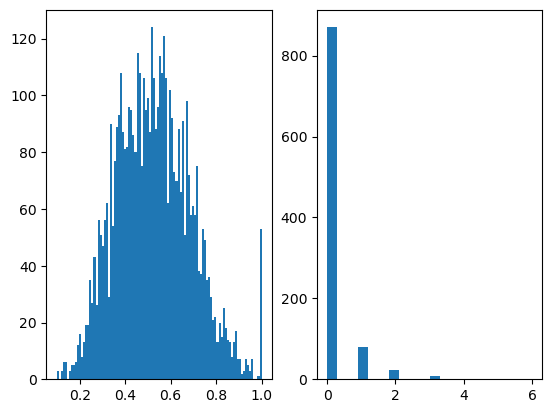

In [14]:
from matplotlib import pyplot as pyt

# sorted = sim.argsort(axis=1)
top_10_values = np.partition(sim, -5)[:, -5:]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.hist(top_10_values.flatten(), bins=100);
count_values_above_085 = np.sum(sim > 0.85, axis=1)
ax2.hist(count_values_above_085, bins=20)


In [15]:
threshold = None
for value in np.linspace(np.min(sim), np.max(sim), num=1000)[::-1]:
    count_above_threshold = np.sum(sim > value, axis=1)
    if np.percentile(count_above_threshold, 75) >= len(sim) * 0.75:
        threshold = value
        break

print("Highest value:", threshold)


Highest value: 0.1971971971971972


True
47
0.24516748816596215


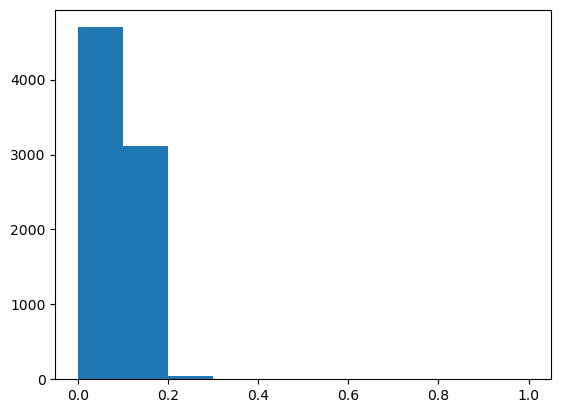

In [16]:
# for i in tqdm(range(len(sim))):
#     sim[i, np.argsort(sim, axis=1)[i]][-100:]

query = "CN(Cc1ccc(Cl)nc1)C(C)=NC#N"
scaffold = GetScaffoldForMol(Chem.MolFromSmiles(query))
generic = MakeScaffoldGeneric(scaffold)
print(Chem.MolToSmiles(generic) in groups)
q_sims = np.array(get_similarities(
    AllChem.GetMorganFingerprint(Chem.MolFromSmiles(query), 2),
    train_fps
))

plt.hist(q_sims)
top_indices = q_sims > 0.2
print(top_indices.sum())
top_similarities = q_sims[top_indices]
print(top_similarities.mean())
top_mols = train[['SMILES', 'logS']].iloc[top_indices]
top_mols.to_csv("../data/temp_dataset.csv", index=False)